# Using k-means Clustering to create Recommendation Engine

## Dataset 
The dataset has two files. We'll import them both into pandas dataframes:

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import helper
from tqdm import tqdm
from sklearn.cluster import KMeans



# import movies from csv into pandas datafram
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
# import ratings by users for the movie
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Now that we know the structure of our dataset, how many records do we have in each of these tables?

In [3]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100004  ratings of  9125  movies.


## Movie-level Clustering
Let's look at how users rated individual movies. We'll shape the dataset in the form of userId vs user rating for each movie. For example, let's look at a subset of the dataset:

In [4]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (671, 9064) 

Subset example:


title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


This is an example of a sparse dataset, as most users didn't rate all movies on this list. Hence the dominance of the NaN values. To deal with the sparse datasets, we try to understadn which moveis were most rated, and we will work with them. (By doing this we will lose some information about some specific tastes of users, who watch mainly low rated movies).
These movies will be sorted by density.

If we're to choose the most-rated movies vs users with the most ratings, it would look like this:

In [5]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = helper.sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Dances with Wolves (1990),Fight Club (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),"Lion King, The (1994)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Apollo 13 (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
29,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,...,5.0,4.0,5.0,4.0,3.0,5.0,3.0,5.0,4.0,2.0
508,4.0,5.0,4.0,4.0,5.0,3.0,4.5,3.0,5.0,2.0,...,5.0,4.0,5.0,4.0,3.5,5.0,4.5,3.0,2.0,4.0
14,1.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,4.0,4.0,...,3.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,4.0
72,5.0,5.0,5.0,4.5,4.5,4.0,4.5,5.0,5.0,3.0,...,4.5,5.0,5.0,5.0,5.0,5.0,5.0,3.5,3.0,5.0
653,4.0,5.0,5.0,4.5,5.0,4.5,5.0,5.0,5.0,5.0,...,4.5,5.0,5.0,4.5,5.0,4.5,5.0,5.0,4.0,5.0


Let's use heatmaps from the helper file, provided to us by Udacity

Let's use colors instead of the number ratings:

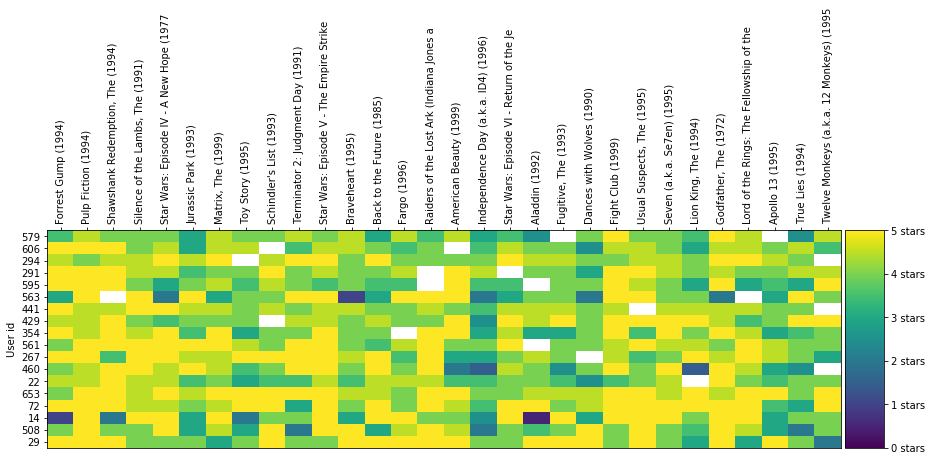

In [6]:
helper.draw_movies_heatmap(most_rated_movies_users_selection)

Each block represents a scoring of a movie by a user. White blocks represent NaN values

k-Means might have some problems clustering as it behaves badly if too much missing values are present.

To shorten computation time and make our analysis easier we will focus on first 1000 most rated moveis.

In [9]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = helper.get_most_rated_movies(user_movie_ratings, 1000)

To use k-means on a dataset with NaN values, we will cast it to 'sparse_csr_matrix' type. We will use to_coo() method to do so.

In [10]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

## Clustering into user segments
With k-means, we have to specify k, the number of clusters. Let's arbitrarily try k=20 (A better way to pick k is as illustrated above with the elbow method. That would take some processing time to run, however.):

In [12]:
sparse_ratings.shape

(671, 1000)

In [24]:

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, 50+1, 5)

# Calculate error values for all k values we're interested in
errors_per_k = [helper.clustering_errors(k, sparse_ratings) for k in tqdm(possible_k_values)]



100%|██████████| 10/10 [01:31<00:00,  9.11s/it]


In [25]:
# Optional: Look at the values of K vs the silhouette score of running K-means with that value of k
list(zip(possible_k_values, errors_per_k))

[(2, 0.3361441019009715),
 (7, 0.05008648136240752),
 (12, -0.010203441122557047),
 (17, -0.010460610780111547),
 (22, -0.013494098963795451),
 (27, -0.004634757192149912),
 (32, -0.009032303383554003),
 (37, -0.004599971307828092),
 (42, -0.007761351355108144),
 (47, -0.008899736310811994)]

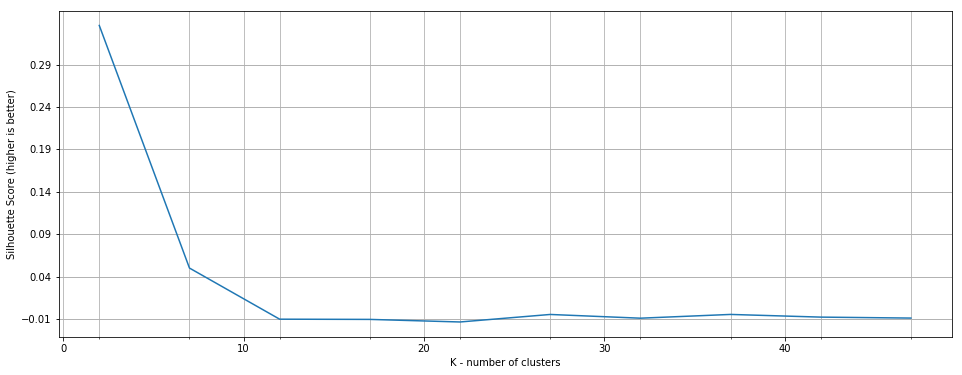

In [26]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), 50+1, 5.0)
#ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We choose 27 number of clusters. Now we use k_means to create user clusters

In [31]:
# use k = 27 
predictions = KMeans(n_clusters=27, algorithm='full').fit_predict(sparse_ratings)

To visualize some of these clusters, we'll plot each cluster as a heat map:

/Users/diasirish/Desktop/programming/NANODEGREE_Machine_Learning_2/netflix_clustering/home/helper.py:115: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
/Users/diasirish/Desktop/programming/NANODEGREE_Machine_Learning_2/netflix_clustering/home/helper.py:116: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)


cluster # 5
# of users in cluster: 284. # of users in plot: 70


/Users/diasirish/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


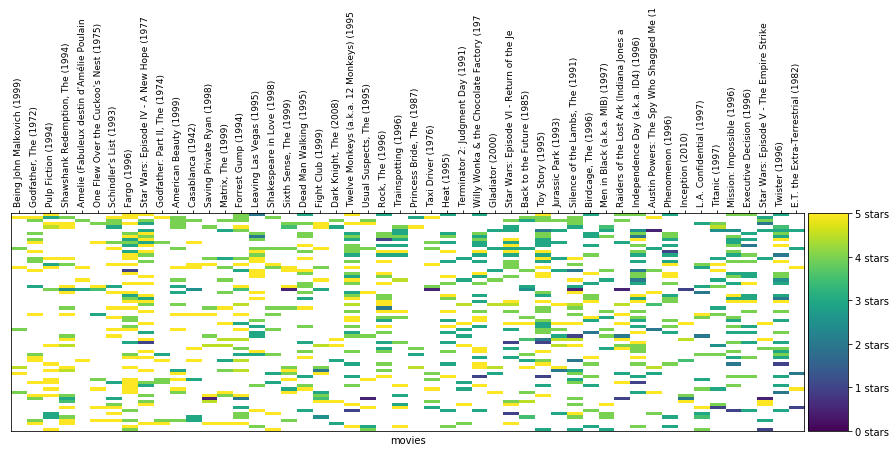

cluster # 14
# of users in cluster: 39. # of users in plot: 39


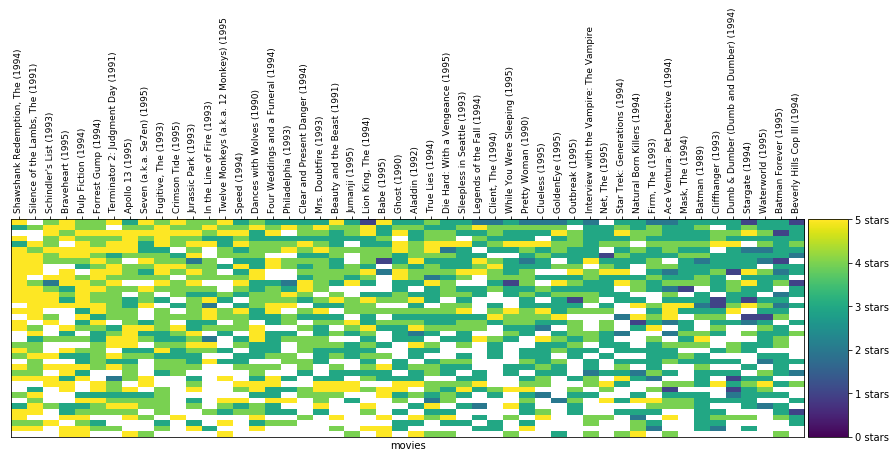

cluster # 12
# of users in cluster: 60. # of users in plot: 60


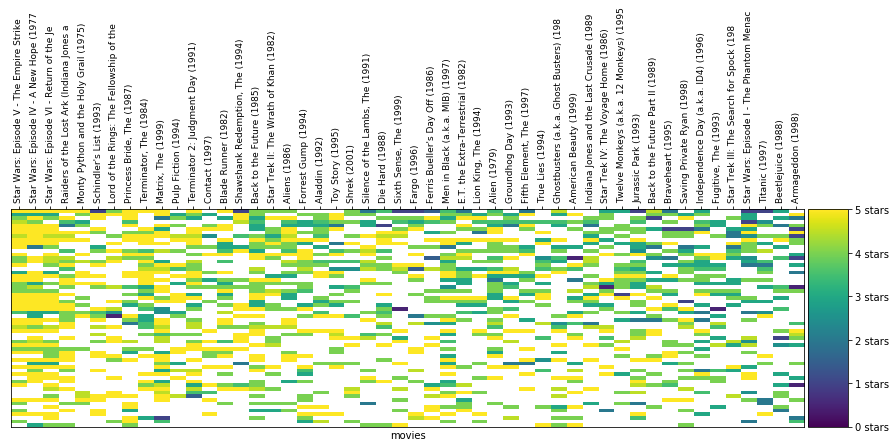

cluster # 11
# of users in cluster: 44. # of users in plot: 44


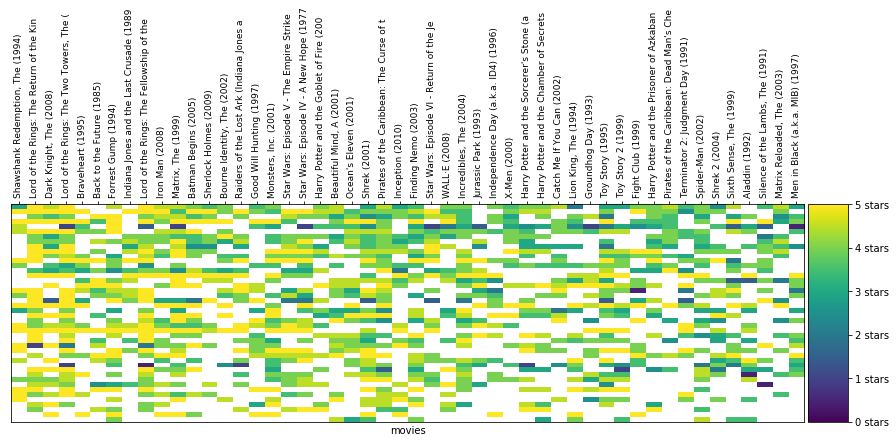

cluster # 16
# of users in cluster: 68. # of users in plot: 68


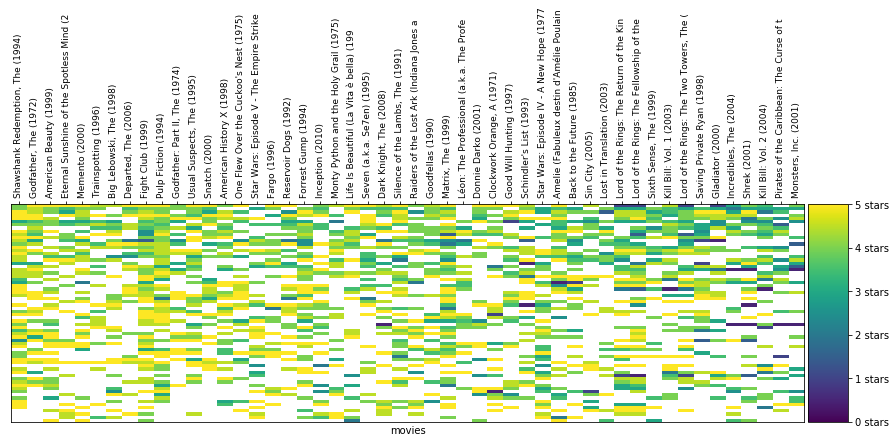

cluster # 6
# of users in cluster: 25. # of users in plot: 25


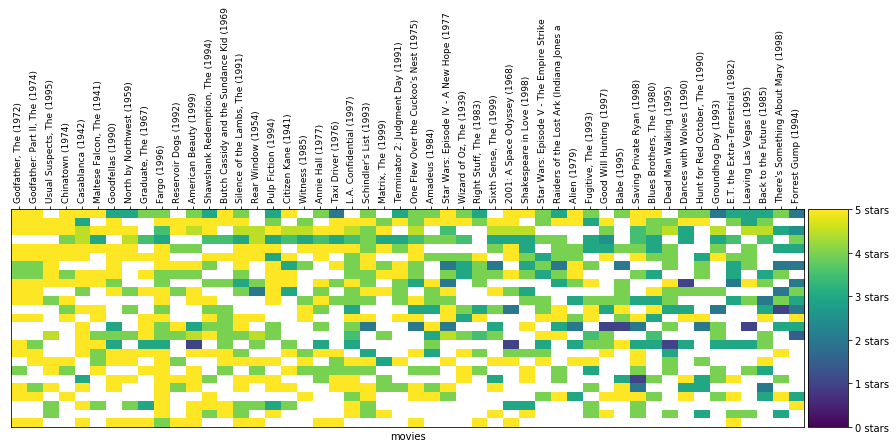

cluster # 0
# of users in cluster: 62. # of users in plot: 62


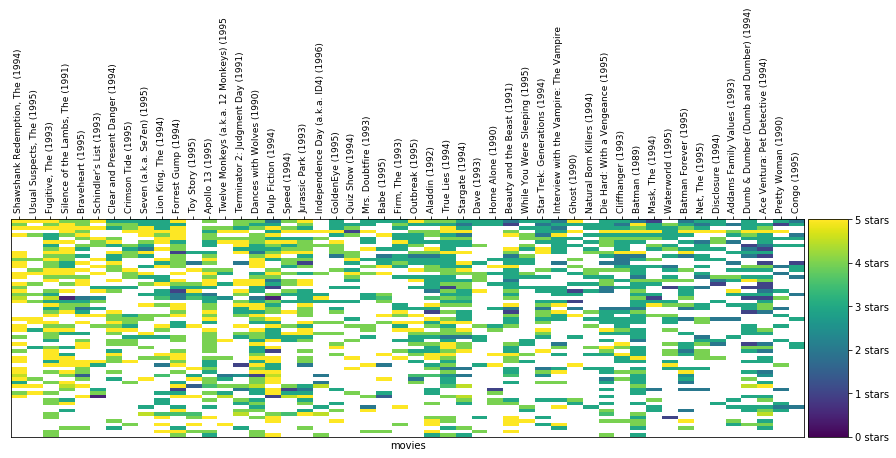

cluster # 4
# of users in cluster: 31. # of users in plot: 31


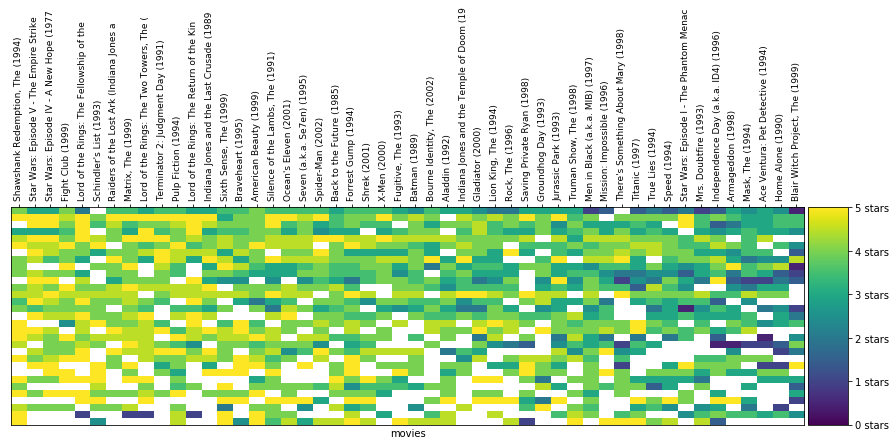

cluster # 2
# of users in cluster: 17. # of users in plot: 17


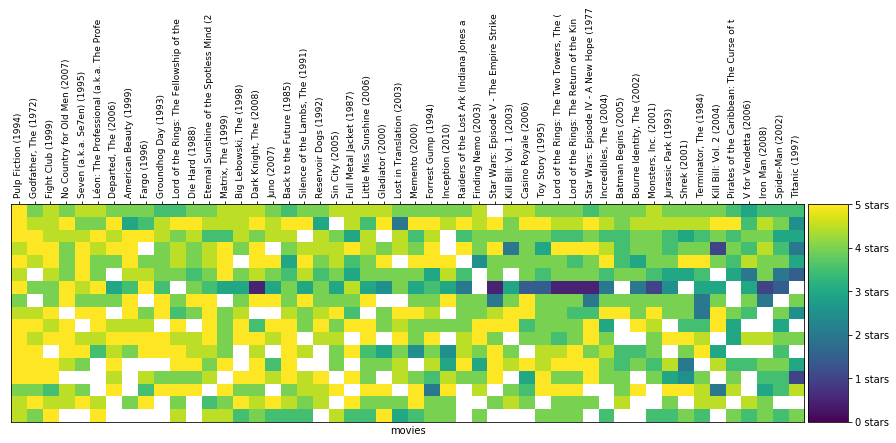

In [32]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
helper.draw_movie_clusters(clustered, max_users, max_movies)

There are several things to note here:
* The more similar the ratings in a cluster are, the more **vertical** lines in similar colors you'll be able to trace in that cluster. 
* It's super interesting to spot trends in clusters:
 * Some clusters are more sparse than others, containing people who probably watch and rate less movies than in other clusters.
 * Some clusters are mostly yellow and bring together people who really love a certain group of movies. Other clusters are mostly green or navy blue meaning they contain people who agree that a certain set of movoies deserves 2-3 stars.
 * Note how the movies change in every cluster. The graph filters the data to only show the most rated movies, and then sorts them by average rating.
* It's easy to spot **horizontal** lines with similar colors, these are users without a lot of variety in their ratings. This is likely one of the reasons for Netflix switching from a stars-based ratings to a thumbs-up/thumbs-down rating. A rating of four stars means different things to different people.
* We did a few things to make the clusters visibile (filtering/sorting/slicing). This is because datasets like this are "sparse" and most cells do not have a value (because most people did not watch most movies). 


## Prediction
Lets look closer into the individual cluster to understand what kind of information we can add

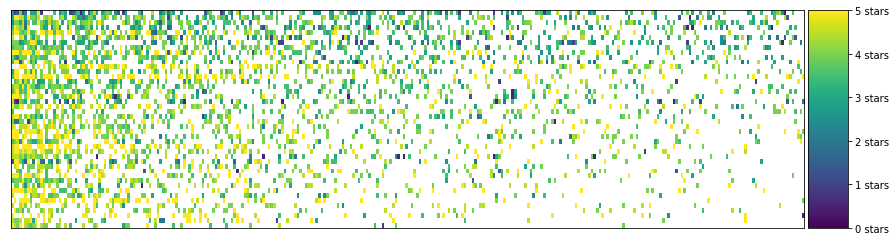

In [36]:
#Pick a cluster ID from the clusters above
cluster_number = 11

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = helper.sort_by_rating_density(cluster, n_movies, n_users)
helper.draw_movies_heatmap(cluster, axis_labels=False)

And the actual ratings in the cluster look like this:

In [37]:
cluster.fillna('').head()

,Shrek (2001),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Matrix, The (1999)",Toy Story (1995),"Lord of the Rings: The Return of the King, The (2003)","Monsters, Inc. (2001)","Incredibles, The (2004)",Finding Nemo (2003),...,Chocolat (2000),The Butterfly Effect (2004),"Ring, The (2002)","Great Escape, The (1963)",Lady and the Tramp (1955),Pleasantville (1998),Fahrenheit 9/11 (2004),"Usual Suspects, The (1995)","Graduate, The (1967)",Stargate (1994)
34,2.5,1,1.5,4,1,2,,3,3,3,...,4.5,2.5,0.5,,,3.5,,,,
30,3,5,5,4.5,4.5,3,5,4,4,3.5,...,,,4.5,1.5,,,,,,
27,2.5,4,4,3,4.5,2,4,,3.5,3.5,...,,,,,,,,,,
13,3.5,5,4.5,4,4.5,2,5,,,,...,,,,,3,,3.5,,,
37,4,5,5,4,3.5,4,5,3.5,3.5,4.5,...,,,,3.5,,,,,,


In [38]:
cluster.describe()   

,Shrek (2001),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Matrix, The (1999)",Toy Story (1995),"Lord of the Rings: The Return of the King, The (2003)","Monsters, Inc. (2001)","Incredibles, The (2004)",Finding Nemo (2003),...,Chocolat (2000),The Butterfly Effect (2004),"Ring, The (2002)","Great Escape, The (1963)",Lady and the Tramp (1955),Pleasantville (1998),Fahrenheit 9/11 (2004),"Usual Suspects, The (1995)","Graduate, The (1967)",Stargate (1994)
count,37.000000,37.000000,36.000000,35.000000,34.000000,34.000000,34.000000,32.000000,32.000000,31.00000,...,5.00000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.00000
mean,4.067568,4.324324,4.263889,4.057143,4.235294,3.882353,4.514706,4.140625,3.953125,4.00000,...,4.10000,2.900000,3.20000,3.100000,3.500000,3.800000,3.200000,4.60000,3.700000,3.10000
std,0.851161,1.048916,1.072288,0.774325,0.923065,1.022910,0.783207,0.721047,0.676320,0.68313,...,0.41833,1.635543,2.04939,1.557241,0.790569,0.273861,0.974679,0.65192,1.095445,1.81659
min,1.500000,1.000000,0.500000,1.500000,1.000000,1.500000,1.000000,3.000000,2.000000,3.00000,...,3.50000,0.500000,0.50000,1.500000,2.500000,3.500000,1.500000,3.50000,2.000000,0.50000
25%,3.500000,4.000000,4.000000,4.000000,3.625000,3.500000,4.000000,3.500000,3.500000,3.50000,...,4.00000,2.500000,1.50000,1.500000,3.000000,3.500000,3.500000,4.50000,3.500000,2.00000
50%,4.500000,5.000000,4.500000,4.000000,4.500000,4.000000,5.000000,4.000000,4.000000,4.00000,...,4.00000,3.000000,4.50000,3.500000,3.500000,4.000000,3.500000,5.00000,4.000000,4.00000
75%,4.500000,5.000000,5.000000,4.500000,5.000000,4.875000,5.000000,5.000000,4.500000,4.50000,...,4.50000,3.500000,4.50000,4.000000,4.000000,4.000000,3.500000,5.00000,4.000000,4.00000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,...,4.50000,5.000000,5.00000,5.000000,4.500000,4.000000,4.000000,5.00000,5.000000,5.00000


Pick a blank cell from the table. It's blank because that user did not rate that movie. Can we predict whether she would like it or not? Since the user is in a cluster of users that seem to have similar taste, we can take the average of the votes for that movie in this cluster, and that would be a reasonable predicition for much she would enjoy the film.

In [39]:
# TODO: Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
# Pick a movie from the table above since we're looking at a subset
movie_name = 'Fight Club (1999)'

cluster[movie_name].mean()

3.8684210526315788

And this would be our prediction for how she'd rate the movie.

## Recommendation
Let's reiterate what we did in the previous step. We have used k-means to cluster users according to their ratings. This lead us to clusters of users with similar ratings and thus generally a similar taste in movies. Based on this, when one user did not have a rating for a certain movie  we averaged the ratings of all the other users in the cluster, and that was our guess to how this one user would like the movie.

Using this logic, if we calculate the average score in this cluster for every movie, we'd have an understanding for how this 'taste cluster' feels about each movie in the dataset. 


In [40]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Shrek (2001)                                                                                      4.067568
Lord of the Rings: The Two Towers, The (2002)                                                     4.324324
Lord of the Rings: The Fellowship of the Ring, The (2001)                                         4.263889
Pirates of the Caribbean: The Curse of the Black Pearl (2003)                                     4.057143
Matrix, The (1999)                                                                                4.235294
Toy Story (1995)                                                                                  3.882353
Lord of the Rings: The Return of the King, The (2003)                                             4.514706
Monsters, Inc. (2001)                                                                             4.140625
Incredibles, The (2004)                                                                           3.953125
Finding Nemo (2003)                  

This becomes really useful for us because we can now use it as a recommendation engine that enables our users to discover movies they're likely to enjoy.

When a user logs in to our app, we can now show them recommendations that are appropriate to their taste. The formula for these recommendations is to select the cluster's highest-rated movies that the user did not rate yet.


In [41]:
# TODO: Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 1

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Grand Budapest Hotel, The (2014)                                  4.800000
Prestige, The (2006)                                              4.687500
Usual Suspects, The (1995)                                        4.600000
The Imitation Game (2014)                                         4.571429
Harry Potter and the Deathly Hallows: Part 2 (2011)               4.545455
Monty Python and the Holy Grail (1975)                            4.500000
Sherlock Holmes: A Game of Shadows (2011)                         4.500000
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)    4.500000
Blood Diamond (2006)                                              4.500000
City of God (Cidade de Deus) (2002)                               4.416667
Green Mile, The (1999)                                            4.416667
Intouchables (2011)                                               4.416667
King's Speech, The (2010)                                         4.400000
Harry Potter and the Deat

And these are our top 20 recommendations to the user!
